In [1]:
import os
import sys
while not os.getcwd().endswith('ml'):
    os.chdir('..')
sys.path.insert(0, os.getcwd())

In [26]:
import pandas as pd
import numpy as np
import copy

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, validation_curve
import matplotlib.pyplot as plt

In [3]:
TARGET_NAME = 'units'

In [4]:
def get_score(y_true, y_predict):
    return math.sqrt(mean_squared_error(y_true, y_predict))

#### Считывание данных

In [5]:
key = pd.read_csv("kaggle/walmart-recruiting-sales-in-stormy-weather/key.csv")
train = pd.read_csv("kaggle/walmart-recruiting-sales-in-stormy-weather/train.csv")
test = pd.read_csv("kaggle/walmart-recruiting-sales-in-stormy-weather/test.csv")
weather = pd.read_csv("kaggle/walmart-recruiting-sales-in-stormy-weather/weather.csv")

#### Описание данных

#### Предобработка данных

In [6]:
def convert_to_minutes(x):
    x.loc[x == "-"] = np.nan
    x.loc[~x.isnull()] = (x[~x.isnull()].astype(int) % 100) + (x[~x.isnull()].astype(int) // 100 * 60)
    x = x.astype(float)

In [7]:
train.sample()

,date,store_nbr,item_nbr,units
467822,2012-04-05,36,69,0


#### Удаление товаров которые никогда не торговались

In [8]:
def get_unclaimed_products(dataset):
    product = np.unique(dataset["product"])
    all_non_empty_product = dataset[dataset["units"] > 0]["product"]
    return set(product) - set(all_non_empty_product)

In [9]:
def add_id_field(dataset):
    dataset["product"] = (dataset["store_nbr"].astype("str") + "_" + dataset["item_nbr"].astype("str")).to_numpy()
    dataset["id"] = (dataset["store_nbr"].astype("str") + "_" + dataset["item_nbr"].astype("str") + "_" + dataset["date"].astype('str')).to_numpy()


In [10]:
add_id_field(train)
add_id_field(test)

unclaimed_products = get_unclaimed_products(train)
unclaimed_ids_from_test = test[test['product'].isin(unclaimed_products)]['id']


#### Предобработка данных

In [11]:
def preprocessing(data, key, weather, target_field=TARGET_NAME):
    data = data.join(key.set_index("store_nbr"), on="store_nbr")
    data = data.join(weather.set_index(["station_nbr", "date"]), on=["station_nbr", "date"])
    
    data.fillna(-1, inplace=True)
    
    result = data
    #result = pd.get_dummies(data, columns=["store_nbr", "item_nbr"])
    if target_field in data.columns:
        result.loc[:, target_field] = np.log(data[target_field] + 1)
    
    datetime_values = pd.to_datetime(data["date"], format="%Y-%m-%d")
    result.loc[:, "timestamp"] = datetime_values.values.astype(np.int64) // 1e9
    result.loc[:, "year"] = datetime_values.dt.year
    result.loc[:, "month"] = datetime_values.dt.month
    result.loc[:, "dayofweek"] = datetime_values.dt.dayofweek
    result.loc[:, "dayofmonth"] = datetime_values.dt.day
    #resul
    result = result.drop(columns=["date", "codesum", "product", "id"])
    return result


In [12]:
weather = weather.replace('M', -1)
weather = weather.replace('  T', 0.001)

for c in set(weather.columns) - set(['date', 'codesum', 'sunrise', 'sunset']):
    weather[c] = pd.to_numeric(weather[c])
    
convert_to_minutes(weather['sunrise'])
convert_to_minutes(weather['sunset'])

mlb = MultiLabelBinarizer()
codesum_data = pd.DataFrame(mlb.fit_transform(weather['codesum'].str.split()),columns=mlb.classes_)
weather_codesum = weather.join(codesum_data.sort_index(axis=1))


preprocessed_train = preprocessing(train[~train['product'].isin(unclaimed_products)], key, weather_codesum)
preprocessed_test = preprocessing(test[~test['product'].isin(unclaimed_products)], key, weather_codesum)

train_columns = preprocessed_train.columns
test_columns = preprocessed_test.columns
diff_columns = list(set(train_columns) - set(test_columns))
diff_columns.remove(TARGET_NAME)
print("Diff of columns {}". format(diff_columns))
for column in diff_columns:
    preprocessed_test[column] = 0 # Add missing field after onehot encoding

/Users/skrrydg/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Diff of columns []


#### Feature importance

In [217]:
persent = 0.1

y = preprocessed_train['units']
X = preprocessed_train.loc[:, preprocessed_train.columns != 'units']

samples = np.random.choice(X.shape[0], int(X.shape[0] * persent), replace=False)

X = X.iloc[samples]
y = y.iloc[samples]

model = RandomForestRegressor(criterion='mse', n_estimators=10, max_depth=30)
model.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [215]:
feature_importance, feature_name = zip(*sorted([ i for i in zip(model.feature_importances_, X.columns)]))

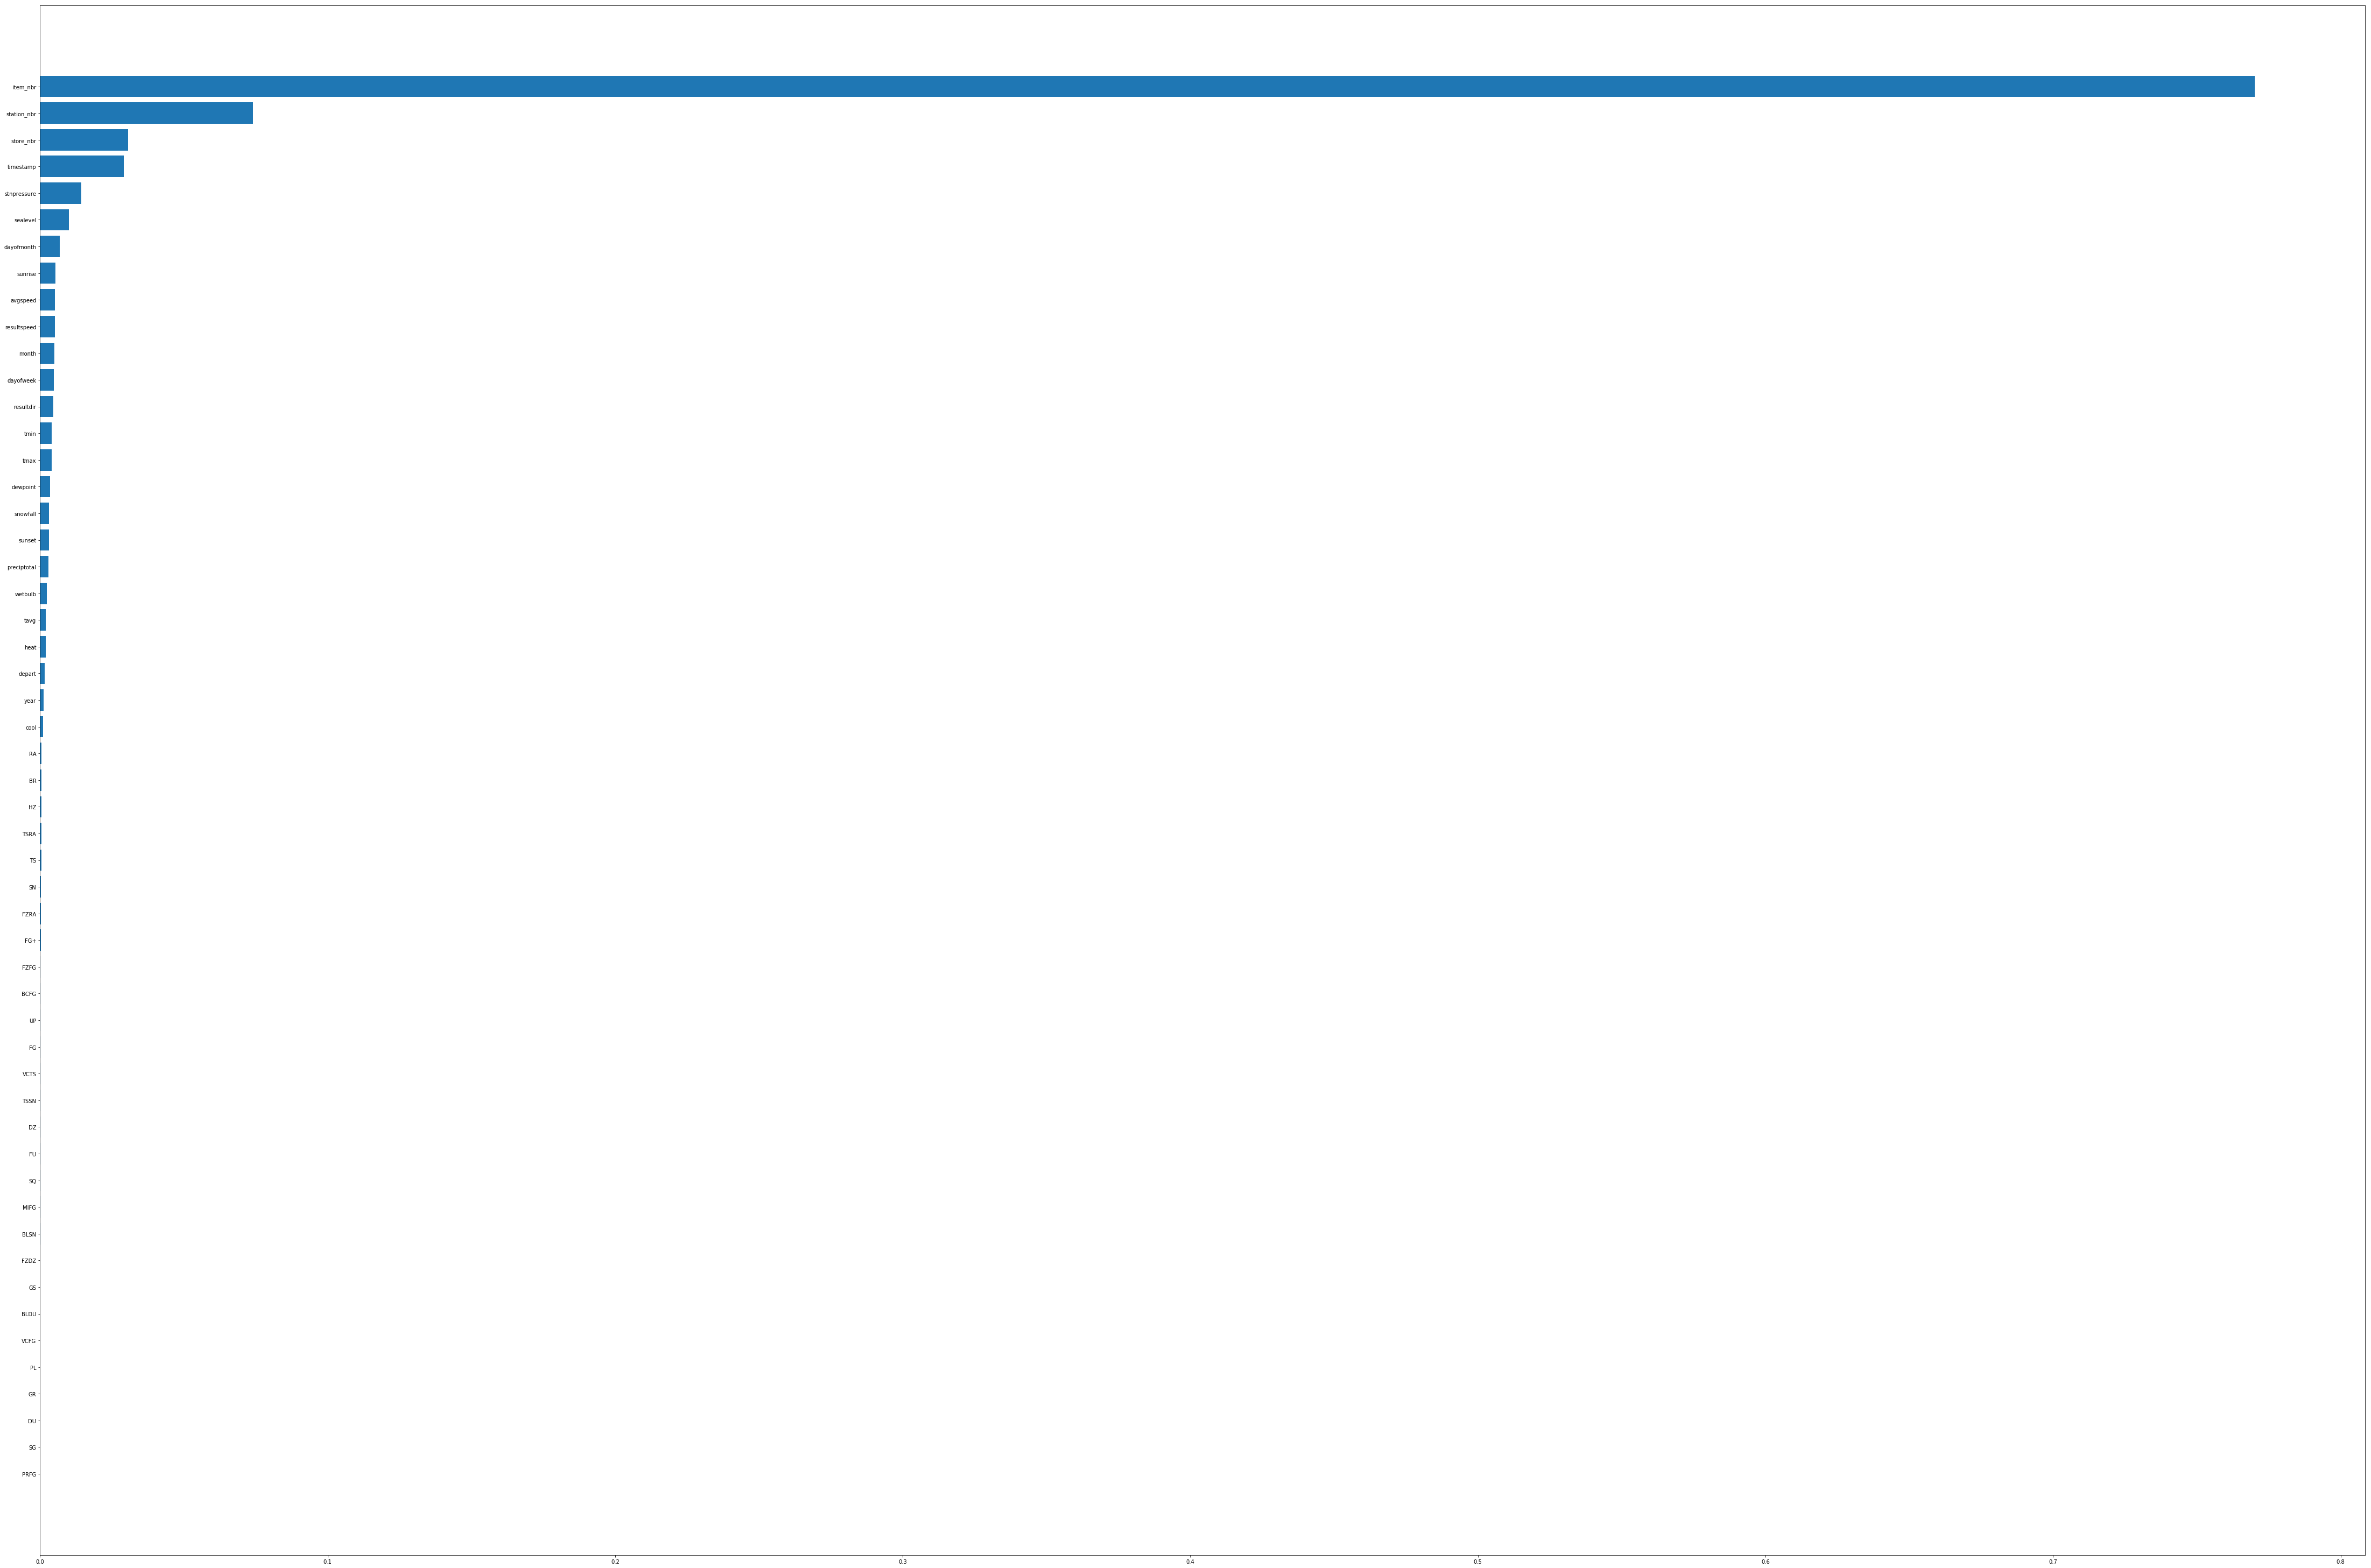

In [216]:
feature_importance, feature_name = zip(*sorted([ i for i in zip(model.feature_importances_, X.columns)]))

fig = plt.figure()
ax = fig.add_axes([0,0,10,10])

ax.barh(feature_name,feature_importance)
plt.show()

#### Валидационнная кривая

In [58]:
persent = 0.1

y = preprocessed_train['units']
X = preprocessed_train.loc[:, preprocessed_train.columns != 'units']

samples = np.random.choice(X.shape[0], int(X.shape[0] * persent), replace=False)

X = X.iloc[samples]
y = y.iloc[samples]

data = [10, 20, 30]

train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestRegressor(criterion='mse', max_depth=25, min_samples_split=5),
                                X = X, y = y, 
                                param_name = 'n_estimators', 
                                param_range = data, 
                                cv = 3,
                                scoring='neg_mean_squared_error')

train_scoreNum = -np.mean(train_scoreNum, axis=1)
test_scoreNum = -np.mean(test_scoreNum, axis=1)

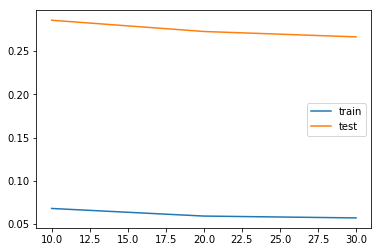

In [59]:
plt.plot(data, train_scoreNum)
plt.plot(data, test_scoreNum)
plt.legend(["train", "test"])
plt.show()

#### Кросвалидация(Модель - GradientBoostingRegressor)

In [62]:
persent = 0.1

y = preprocessed_train['units']
X = preprocessed_train.loc[:, preprocessed_train.columns != 'units']

samples = np.random.choice(X.shape[0], int(X.shape[0] * persent), replace=False)

X = X.iloc[samples]
y = y.iloc[samples]


n_estimators = [100]
max_depth = [25]
min_samples_split = [2, 5, 10, 15]

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split)

model = GradientBoostingRegressor(criterion='mse')

gridF = GridSearchCV(model, 
                     hyperF, 
                     cv = 3, 
                     verbose = 1, 
                     n_jobs = -1,
                     scoring='neg_mean_squared_error')

bestF = gridF.fit(X, y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  6.0min remaining:  1.2min


KeyboardInterrupt: 

In [ ]:
print(bestF.best_params_, bestF.best_score_)

#### Кросвалидация(Модель - лес)

In [13]:
persent = 0.1

y = preprocessed_train['units']
X = preprocessed_train.loc[:, preprocessed_train.columns != 'units']

samples = np.random.choice(X.shape[0], int(X.shape[0] * persent), replace=False)

X = X.iloc[samples]
y = y.iloc[samples]


n_estimators = [100, 500, 1000]
max_depth = [25, 30]
min_samples_split = [2, 5, 10, 15]

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split)

model = RandomForestRegressor(criterion='mse')

gridF = GridSearchCV(model, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)

bestF = gridF.fit(X, y)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 21.3min finished


In [23]:
print(bestF.best_params_, bestF.best_score_)

{'max_depth': 25, 'min_samples_split': 5, 'n_estimators': 1000} 0.9175706750322268


#### Обучение модели(лес)

In [15]:
y = preprocessed_train['units']
X = preprocessed_train.loc[:, preprocessed_train.columns != 'units']

In [16]:
model = RandomForestRegressor(criterion='mse', **bestF.best_params_)

In [17]:
model.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#### Обучение модели(GradientBoostingRegressor)

In [ ]:
y = preprocessed_train['units']
X = preprocessed_train.loc[:, preprocessed_train.columns != 'units']

In [ ]:
model = GradientBoostingRegressor(criterion='mse', **bestF.best_params_)

In [ ]:
model.fit(X, y)

#### Предсказание

In [ ]:
y_predict = model.predict(preprocessed_test)
y_predict = np.exp(y_predict) - 1

In [ ]:
cleared_test = test[~test['product'].isin(unclaimed_products)]
_id = (cleared_test["store_nbr"].astype("str") + "_" + cleared_test["item_nbr"].astype("str") + "_" + cleared_test["date"].astype('str')).to_numpy()
_units = y_predict

In [ ]:
_id = np.append(_id, unclaimed_ids_from_test)
_units = np.append(_units, np.zeros(shape=(len(unclaimed_ids_from_test))))

In [ ]:
prediction = pd.DataFrame(data={"id": _id, "units": _units}).set_index("id") 
prediction.to_csv("kaggle/walmart-recruiting-sales-in-stormy-weather/submissions/GradientBoostingRegressor1.csv")